# Aim

Try out an LQG delay model and see if it optimally controls a toy AR problem.

In [343]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
from scipy import signal as sig
from scipy.stats import multivariate_normal as mvn

from sealrtc.controllers import LQG, Openloop, Integrator
from sealrtc.controllers.identifier import vib_coeffs
from sealrtc.controllers.dare import solve_dare
from sealrtc import rms
from sealrtc.utils import make_impulse_2, make_tf2

%load_ext jupyter_spaces
%load_ext autoreload
%autoreload 2

The jupyter_spaces extension is already loaded. To reload it, use:
  %reload_ext jupyter_spaces
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [272]:
# constants
fs = 100.0 # Hz
dt = 1 / fs # s
fcen = 10.0 # Hz
k = 1e-2
sigma_w = 0.1
sigma_v = 0.1
a1, a2 = vib_coeffs(fcen, k)

In [304]:
# system matrices for a sliiiightly wrong model
lqg_vib = LQG(
    np.array([[a1, a2], [1, 0]]),
    np.array([[1], [0]]),
    np.array([[1, 0]]),
    np.array([[0]]),
    np.array([[sigma_w ** 2, 0], [0, 0]]),
    np.array([[sigma_v ** 2]]),
)
ol = Openloop(1)
integ = Integrator(2, 1, gain=0.5)

lqg_vib

Solved DARE with slycot.
Solved DARE with slycot.


LQG observer and controller with state size 2, input size 1 and measurement size 1.

In [324]:
lqg_vib.improvement([ol, integ])

100%|██████████| 999/999 [00:00<00:00, 1791.70it/s]


[5.284291573516702, 3.9449620497150044]

Seems good enough, but of course these aren't the actual dynamics: I've got the input hitting the vibration mode, and of course it doesn't work that way. Instead, here's a steering-model vibration, with no delay.

Our state was previously $\vec{x}[n] = \begin{bmatrix} x_n & x_{n-1} \end{bmatrix}$, and will now be $\vec{x}[n] = \begin{bmatrix} x_n & x_{n-1} & u_n\end{bmatrix}$.

Something is clearly wrong with this steering idea.

Apparently A-C-D control doesn't need an ARE at all. I'll try writing that in an ad hoc way, see if it does anything to the control problem, and then add it into the LQG class if it works.

Poyneer and Veran (2010) claims you can do this in what I'm calling A-B-C control, and they provide the matrices.

In principle, we should have a full state-space description, [A B C D], because B terms would be needed for any steering that affects the actual underlying random process that's causing the motion. Such as...a generic nth-order plant model! 

In [330]:
nsteps = 10000
M = np.random.random((2,2))
d = np.diag(np.random.random((2,))) 
d /= (1.01 * np.max(d))
A = inv(M) @ d @ M
B = np.array([[0], [0]])
C = np.array([[1, 0]])
D = np.array([[1]])
W = np.array([[0.1, 0], [0, 0]])
V = np.array([[0.001]])
abcd = LQG(A, B, C, D, W, V)

Solved DARE with slycot.
Solved DARE with slycot.


100%|██████████| 9999/9999 [00:05<00:00, 1699.07it/s]


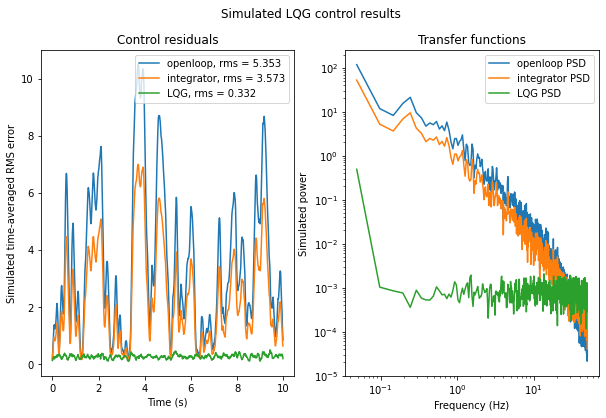

In [331]:
_ = abcd.simulate([ol, integ], nsteps=nsteps, plot=True)

Next up, let's try a plant model in here

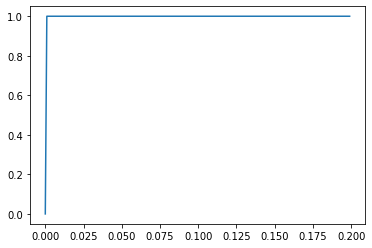

In [491]:
tf = sig.TransferFunction([omega ** 2], [1, 2 * z * omega, omega ** 2])
tf = make_tf2(overshoot=0.00001, peak_time=0.00001)
t, y = sig.step(tf, T=np.arange(0, 0.2, 0.001))
plt.plot(t, np.squeeze(y))

In [492]:
ss = tf.to_ss()
ss2 = sig.cont2discrete((ss.A, ss.B, ss.C, ss.D), dt=0.01)

In [502]:
ss

StateSpaceContinuous(
array([[-2.30258509e+06, -1.42417057e+12],
       [ 1.00000000e+00,  0.00000000e+00]]),
array([[1.],
       [0.]]),
array([[0.00000000e+00, 1.42417057e+12]]),
array([[0.]]),
dt: None
)

In [504]:
A, B, C, D = ss.A, ss.B, ss.C, ss.D
W = 0.1 * np.eye(2)
V = 0.01 * np.eye(1)
plant = LQG(A, B, C, D, W, V)

Solved DARE with slycot.
Solved DARE with slycot.


  0%|          | 0/999 [00:00<?, ?it/s]/Users/adityasengupta/research/ao/sealrtc/sealrtc/controllers/lqg.py:136: RuntimeWarning: overflow encountered in matmul
  m[j-1] = self.C @ s[j-1] + self.D @ i[j-1] + measure_noise
/Users/adityasengupta/research/ao/sealrtc/sealrtc/controllers/lqg.py:138: RuntimeWarning: overflow encountered in matmul
  s[j] = self.A @ s[j-1] + self.B @ i[j] + process_noise
/Users/adityasengupta/research/ao/sealrtc/sealrtc/controllers/lqg.py:138: RuntimeWarning: invalid value encountered in matmul
  s[j] = self.A @ s[j-1] + self.B @ i[j] + process_noise
100%|██████████| 999/999 [00:00<00:00, 1749.60it/s]
/Users/adityasengupta/opt/anaconda3/envs/seal/lib/python3.9/site-packages/numpy/linalg/linalg.py:2559: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/adityasengupta/opt/anaconda3/envs/seal/lib/python3.9/site-packages/numpy/linalg/linalg.py:2559: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


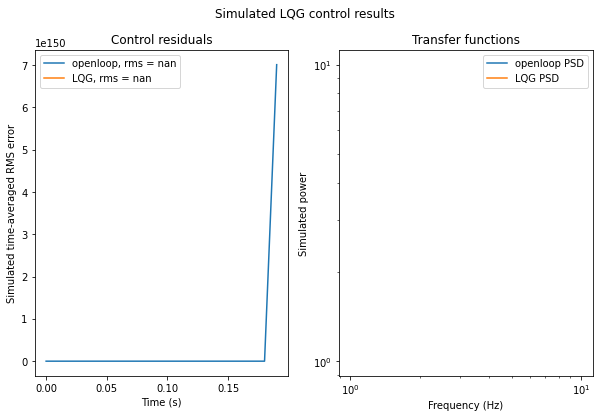

In [506]:
plant.reset()
plant.simulate([ol], plot=True);

Solved DARE with slycot.
Solved DARE with slycot.


100%|██████████| 999/999 [00:00<00:00, 2579.03it/s]


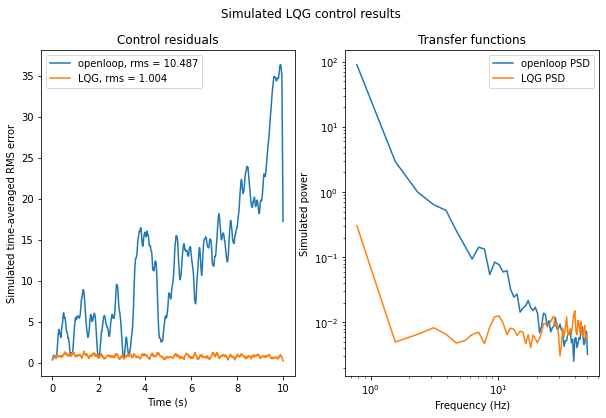

In [500]:
identity = LQG(np.eye(1), np.array([[1]]), np.array([[1]]), np.array([[0]]), np.eye(1), 0.01 * np.eye(1))
identity.simulate([ol], plot=True);

Solved DARE with slycot.
Solved DARE with slycot.


100%|██████████| 999/999 [00:00<00:00, 2131.26it/s]


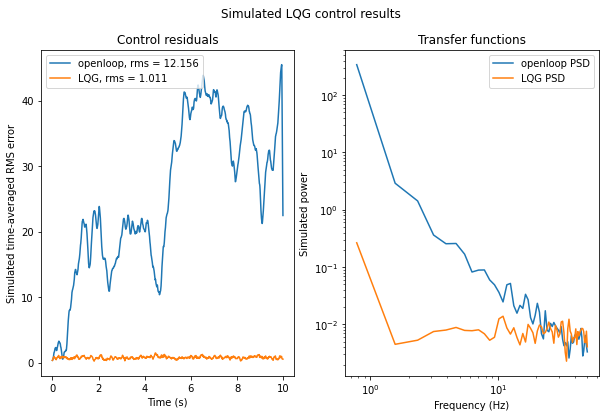

In [514]:
stay_still = LQG(
    np.eye(1),
    np.array([[1]]),
    np.eye(1),
    np.array([[0]]),
    np.eye(1),
    0.01 * np.eye(1)
)
stay_still.simulate();

Solved DARE with slycot.
Solved DARE with slycot.


100%|██████████| 999/999 [00:01<00:00, 858.18it/s]


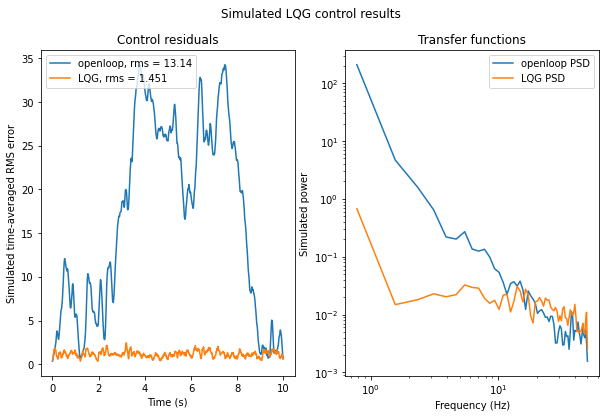

In [519]:
still_delay = LQG(
    np.array([[1, 1], [0, 0]]),
    np.array(([0], [1])),
    np.array(([[1, 0]])),
    np.array([[0]]),
    np.array([[1, 0], [0, 0]]),
    np.array([[0.01]])
)
still_delay.simulate();

In [555]:
def add_delay(lqg, d=1):
    """
    Takes in a system of the form x[k+1] = Ax[k] + Bu[k]; y[k] = Cx[k] + Du[k], 
    and converts it to a system of the form x[k+1] = Ax[k] + Bu[k-d]; y[k] = Cx[k] + Du[k-d].
    """
    if d == 0:
        return lqg
    s = lqg.state_size
    p = lqg.input_size
    m = lqg.measure_size
    A = np.zeros((s+p*d, s+p*d))
    A[:s, :s] = lqg.A
    A[:s,(s+(d-1)*p):((s+d*p))] = lqg.B

    for i in range(1, d):
        A[(s+i*p):(s+(i+1)*p), (s+(i-1)*p):(s+i*p)] = np.eye(p)

    B = np.zeros((s+p*d, p))
    B[s:s+p,:] = np.eye(p)
    C = np.zeros((m, s+p*d))
    C[:,:s] = lqg.C
    C[:,(s+p*(d-1)):] = lqg.D
    D = np.zeros((m, p))
    W = np.zeros((s + p*d, s + p*d))
    W[:s, :s] = lqg.W
    return LQG(A, B, C, D, W, V)


Solved DARE with slycot.
Solved DARE with slycot.


100%|██████████| 9999/9999 [00:05<00:00, 1870.23it/s]


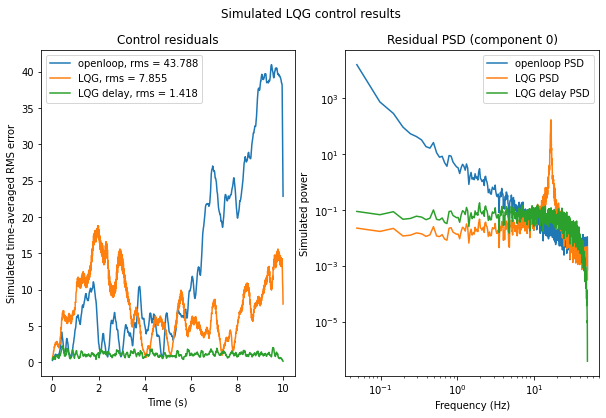

In [603]:
still_delay = add_delay(stay_still, d=1)
still_delay.name = "LQG delay"
resol, reslqg, reslqg_delay = still_delay.simulate(stay_still, nsteps=10000);

In [604]:
from sealrtc import genpsd
from sealrtc.controllers.identifier import find_psd_peaks
freqs, psd = genpsd(reslqg[2][:,0], dt=1/fs)

In [605]:
find_psd_peaks(freqs, psd)

array([16.74804688, 16.6015625 , 16.9921875 ])

In [718]:
damp = 0.1
omega = 0.8
real_p = -damp * omega
imag_p = omega * np.sqrt(1 - damp ** 2)
tf = sig.TransferFunction([1], [1, 2 * real_p, real_p ** 2 + imag_p ** 2])

In [720]:
ss = tf.to_ss()
plant = LQG(ss.A, ss.B, ss.C, ss.D, np.array([[0.01, 0], [0, 0.01]]), np.array([[0.01]]))
plant.reset()

Solved DARE with slycot.
Solved DARE with slycot.


100%|██████████| 999/999 [00:00<00:00, 1710.46it/s]


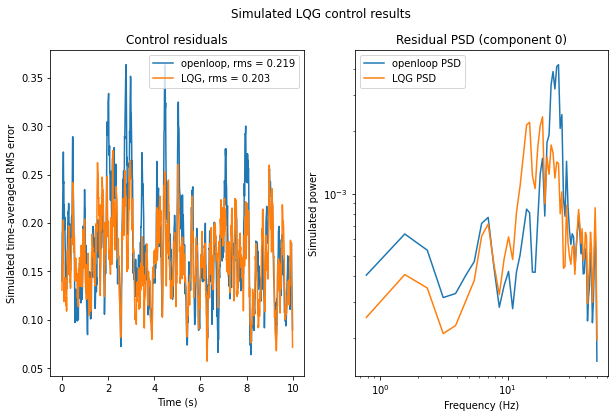

In [721]:
plant.simulate();